# **Tutorial 2: Reconstructing Past Changes in Ocean Climate**
**Week 1, Day 4, Paleoclimate**

**Content creators:** Sloane Garelick

**Content reviewers:** Yosmely Bermúdez, Dionessa Biton, Katrina Dobson, Maria Gonzalez, Will Gregory, Nahid Hasan, Sherry Mi, Beatriz Cosenza Muralles, Brodie Pearson, Jenna Pearson, Chi Zhang, Ohad Zivan 

**Content editors:** Yosmely Bermúdez, Zahra Khodakaramimaghsoud, Jenna Pearson, Agustina Pesce, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS

# **Tutorial Objectives**

In the previous days, you learned about the El Niño–Southern Oscillation (ENSO), and have explored how satellite data can be employed to track this phenomenon during the instrumental period. In this tutorial, you will explore how oxygen isotopes of corals can record changes in temperature associated with the phase of ENSO even further back in time.

By the end of this tutorial you will be able to:

*   Understand the types of marine proxies that are used to reconstruct past climate
*   Create a stacked plot and warming stripe to visualize ENSO temperature reconstructions


# **Setup**


In [3]:
# !pip install Pandas
# !pip install pooch
# !pip install cartopy
# !pip install pyleoclim

In [4]:
# imports
import pandas as pd
import numpy as np
import pooch
import cartopy
import pyleoclim as pyleo
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import patches

In [5]:
# @title Video 1: Speaker Introduction
#Tech team will add code to format and display the video

# Section 1: Assessing Variability Related to El Niño Using Pyleoclim Series

ENSO is a recurring climate pattern involving changes in SST in the central and eastern tropical Pacific Ocean.  As we learned in the introductory video, oxygen isotopes (d18O) of corals are a commonly used proxy for reconstructing changes in tropical Pacific SST and ENSO.  Long-lived corals are well-suited for studying paleo-ENSO variability because they store decades to centuries of sub-annually resolved proxy information in the tropical Pacific. The oxygen isotopes of corals are useful for studying ENSO because they record changes in sea-surface temperature (SST), with with more positive values of d18O corresponding to colder SSTs, and vice-versa.

One approach for detecting ENSO from coral isotope data is applying a 2- to 7-year bandpass filter to the d18O records to highlight ENSO-related variability and compare (quantitatively) the bandpassed coral records to the Oceanic Niño Index you learned about in Day 2 and Day 3. While we won't be going into this amount of detail, you may utilize the methods sections of these papers as a guide: [Cobb et al.(2003)](https://www.nature.com/articles/nature01779), [Cobb et al.(2013)](https://www.science.org/doi/10.1126/science.1228246). In this tutorial we will be looking at the d18O records and comparing to a plot of the ONI without this band-pass filtering, in part to highlight why the filtering is needed.

## Section 1.1: Load coral oxygen isotope proxy reconstructions

The two coral records we'll look at are from [Palmyra Atoll](https://en.wikipedia.org/wiki/Palmyra_Atoll) and [Line Islands](https://en.wikipedia.org/wiki/Line_Islands), both of which are in the tropical central Pacific Ocean.

Let's plot these approximate locations as well as the Niño 3.4 region you are familiar with from the first three days.

/Users/jennapearson/anaconda3/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/jennapearson/anaconda3/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/jennapearson/anaconda3/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


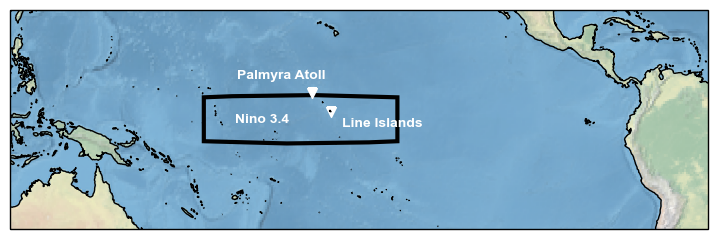

In [6]:
# select data for the month of interest
# data = precip.sel(time='1979-01-01', method='nearest')
 
# initate plot with the specific figure size
fig = plt.figure(figsize=(9,6))

# set base map projection
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))

# add background image to show land and sea
ax.stock_img()

# add coastlines
ax.add_feature(cfeature.COASTLINE)

# add in rectangle showing Nino 3.4 region
rectangle = patches.Rectangle((170, -5),50, 10, transform=ccrs.Geodetic(),edgecolor='k',
facecolor="none", linewidth=3)
ax.add_patch(rectangle)

rx, ry = rectangle.get_xy()
cx = rx + rectangle.get_width()/2.0
cy = ry + rectangle.get_height()/2.0

# add labels
ax.annotate("Nino 3.4", (cx-10,cy), color='w', transform=ccrs.PlateCarree(), weight='bold', fontsize=10, ha='center', va='center')

# add the proxy locations
ax.scatter([-162.078333],[5.883611],transform=ccrs.Geodetic(),
          s= 50, marker = 'v',color = 'w')
ax.scatter([-157.2],[1.7],transform=ccrs.Geodetic(),
          s= 50, marker = 'v',color = 'w')

# add labels
ax.annotate("Palmyra Atoll", (-170,10), color='w', transform=ccrs.Geodetic(), weight='bold', fontsize=10, ha='center', va='center')

ax.annotate("Line Islands", (-144,-1), color='w', transform=ccrs.Geodetic(), weight='bold', fontsize=10, ha='center', va='center')

# change the map view to zoom in on central Pacific
ax.set_extent((120, 300, -25, 25), crs =ccrs.PlateCarree())



To analyze and visualize paleoclimate proxy time series, we will be using [Pyleoclim](https://pyleoclim-util.readthedocs.io/en/latest/). Pycleoclim is specifically designed for the analysis of paleoclimate data. The package is designed around object-oriented `Series`, which can be directly manipulated for plotting and time series-appropriate analysis and operation. 

The `Series` object describes the fundamentals of a time series. To create a Pyleoclim `Series`, we first need to load the data set, and then specify values for its various properties:

*   `time`: Time values for the time series
*   `value`: Paleo values for the time series
*   `time_name` (optional): Name of the time vector, (e.g., 'Time', 'Age'). This is used to label the x-axis on plots
*   `time_unit` (optional): The units of the time axis (e.g., 'years')
*   `value_name` (optional): The name of the paleo variable (e.g., 'Temperature')
*   `value_unit` (optional): The units of the paleo variable (e.g., 'deg C')
*   `label` (optional): Name of the time series (e.g., 'Nino 3.4')
*   `clean_ts` (optional): If True (default), remove NaNs and set an increasing time axis

A common data format for datasets downloaded from the NOAA Paleoclimate Database is a templated text file, which contains helpful data and metadata. 

Take a look at our two datasets [here](https://www.ncei.noaa.gov/pub/data/paleo/coral/east_pacific/palmyra_2003.txt) and [here](https://www.ncei.noaa.gov/pub/data/paleo/coral/east_pacific/cobb2013-fan-modsplice-noaa.txt).

The functionality in python allows us to ignore all of the information at the beginning of the text files, and we can load the data directly into a `pandas.DataFrame` using `.read_csv()`.

### Section 1.1.1: Load Palmyra coral data

In [7]:
# download the data using the url
data_path = pooch.retrieve(
    url='https://www.ncei.noaa.gov/pub/data/paleo/coral/east_pacific/palmyra_2003.txt',
    known_hash=None
)

# from the data set, we only want the data related to Modern Living Coral.
# this data is between row 6190 and 7539 of the dataset
rows = [int(row) for row in np.linspace(6190, 7539, 7539 - 6190 + 1)]

# use pandas to read in the csv file
palmyra = pd.read_csv(
    data_path,
    skiprows=lambda x: x not in rows, # number of rows to skip based on definition of rows above
    sep='\s+',                        # how the data values are seperated (delimited) : '\s+' = space
    encoding = 'ISO-8859-1',
    names=['CalendarDate', 'd180'],
    header=None,
)

palmyra.head()

,CalendarDate,d180
0,1886.13,-4.79
1,1886.21,-4.89
2,1886.29,-4.81
3,1886.38,-4.84
4,1886.46,-4.85


Now that we have the data in a dataframe, we can pull the relevant columns of this datframe into a `Series` object in Pyleoclim, which will allow us to organize the relevant metadata so that we can get a well-labeled, publication-quality plot:

In [8]:
ts_palmyra = pyleo.Series(
    time=palmyra['CalendarDate'],
    value=palmyra['d180'],
    time_name='Calendar date',
    time_unit='Years',
    value_name = r'$d18O$',
    value_unit='per mille',
    label='Palmyra Coral'
)

Time axis values sorted in ascending order


Since we want to compare two SST datasets based on different measurements (observations and proxies), it's helpful to standardize the data by removing it's estimated mean and dividing by its estimated standard deviation. Thankfully Pyleoclim has a [function](https://pyleoclim-util.readthedocs.io/en/v0.7.4/core/ui.html#pyleoclim.core.ui.Series.standardize) to that for us.

In [9]:
palmyra_stnd = ts_palmyra.standardize()
palmyra_stnd

{'label': 'Palmyra Coral'}


None
Calendar date [Years]
1886.13    0.554248
1886.21    0.109927
1886.29    0.465384
1886.38    0.332088
1886.46    0.287655
             ...   
1998.04   -2.289410
1998.13   -2.556003
1998.21   -2.467139
1998.29   -2.200546
1998.38   -1.534064
Name: $d18O$ [per mille], Length: 1348, dtype: float64

### Section 1.1.2: Load Line Island coral data

We will repeat these steps for the other dataset.

In [10]:
# Download the data using the url
data_path2 = pooch.retrieve(
    url='https://www.ncei.noaa.gov/pub/data/paleo/coral/east_pacific/cobb2013-fan-modsplice-noaa.txt',
    known_hash=None
)
# From the data set, we only want the data related to Modern Living Coral.
# So this data is between row 6190 and 7539 of the dataset
rows = [int(row) for row in np.linspace(127, 800, 800 - 127 + 1)]
line = pd.read_csv(
    data_path2, 
    skiprows=lambda x: x not in rows, 
    sep='\s+',
    encoding = 'ISO-8859-1',
    names=['age', 'd18O'],
    header=None,
)

line.head()

,age,d18O
0,1949.54,-4.62
1,1949.63,-4.76
2,1949.71,-4.73
3,1949.79,-4.66
4,1949.88,-4.60


In [11]:
ts_line = pyleo.Series(
    time=line['age'],
    value=line['d18O'],
    time_name='Calendar date',
    time_unit='Years',
    value_name = r'$d18O$',
    value_unit='per mille',
    label='Line Island Coral'
)

Time axis values sorted in ascending order


In [12]:
line_stnd = ts_line.standardize()
line_stnd

{'label': 'Line Island Coral'}


None
Calendar date [Years]
1949.54    1.754839
1949.63    1.161645
1949.71    1.288758
1949.79    1.585355
1949.88    1.839581
             ...   
2005.21   -0.660308
2005.29   -0.872162
2005.38    0.017628
2005.46    0.059999
2005.54   -0.448453
Name: $d18O$ [per mille], Length: 673, dtype: float64

# Section 2: Plot the Data Using Multiseries

We will utilize the built in features of a [multiseries](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#multipleseries-pyleoclim-multipleseries) object to plot our coral proxy data side by side. To create a `pyleo.MultipleSeries`, we first create a list with our `pyleo.Series` objects and then pass this into a `pyleo.MultipleSeries`.

In [13]:
# combine into a list
nino_comparison = [palmyra_stnd, line_stnd]

In [14]:
# create multiseries
nino = pyleo.MultipleSeries(nino_comparison, name='El Nino Comparison')

/var/folders/k2/707t_q4135v27q7hpn6490nh0000gp/T/ipykernel_55316/1158577361.py:2: DeprecationWarning: `name` is a deprecated property, which will be removed in future releases, Please use `label` instead
  nino = pyleo.MultipleSeries(nino_comparison, name='El Nino Comparison')


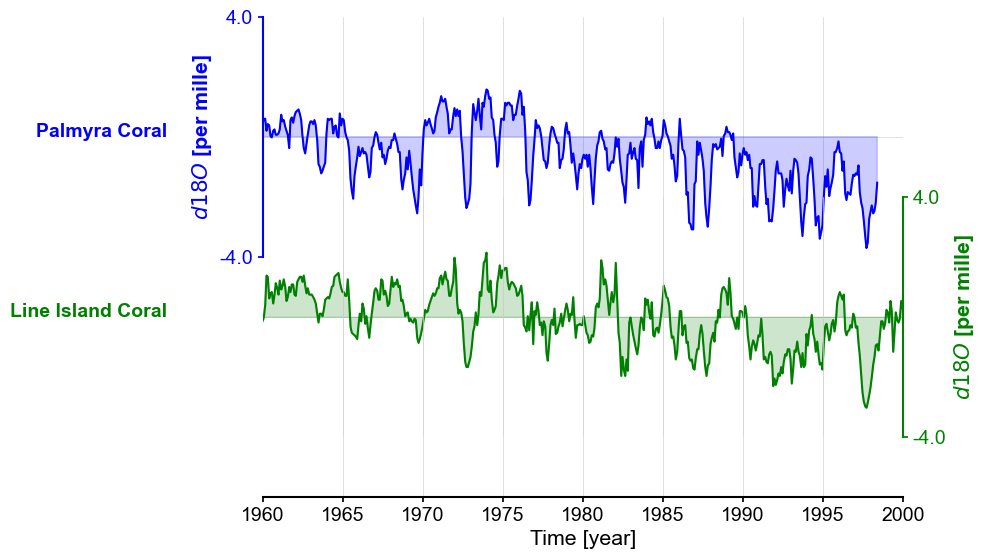

In [18]:
# plot the time series of both datasets
fig, ax = nino.stackplot(time_unit="year",xlim=[1960,2000], colors = ['b','g'])

## Questions 2: Climate Connection

Recall that as SST becomes colder, d18O becomes more positive, and vice versa. Compare the figure below to the time series of d18O you plotted earlier and answer the questions below.

![](https://climatedataguide.ucar.edu/sites/default/files/styles/extra_large/public/2022-03/indices_oni_2_2_lg.png?itok=Zew3VK_4)

Credit: [UCAR](https://climatedataguide.ucar.edu/sites/default/files/styles/extra_large/public/2022-03/indices_oni_2_2_lg.png?itok=Zew3VK_4)

1. Do the ENSO events recorded by the ONI agree with the coral data?
2. What are some considerations you can think of when comparing proxies such as this to the ONI?


In [ ]:
# to_remove explanation  

"""
1. In general when there is a recorded ENSO event in the ONI, there is an agreement with the coral records.  During El Nino Phases captured by the ONI (where SSTs are anomolously warm) we typically see a more negative d18O and vicer versa for La Nina events. 
2. ENSO is an interannual occurence, happening every 2-7 years. Within the d18O records there are high frequency signals. One thing (among many) shwe could do is remove these by filtering. This would help resolve our dataset into something more comparable to what the ONI is tracking.
""";

# **Section 1.3: Make Warming Stripes Plot**

We can also make a warming stripe for this data `Series` using the [`.stripes()`](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#pyleoclim.core.multipleseries.MultipleSeries.stripes) method, where darker red stripes indicate a warmer eastern Pacific and possibly an El Niño phase, and darker blue stripes indicate a cooler eastern Pacific and possibly La Niña phase. Can you see the trend present in the data?

In [ ]:
fig, ax = nino.stripes(ref_period=(1960,1990), time_unit="year", show_xaxis = True, cmap = 'RdBu')

# **Summary**
In this tutorial, we discovered how oxygen isotopes within corals serve as a valuable archive, recording changes in temperature associated with ENSO phases.

During our explorations, 
- We ventured into the study of proxy-based coral d18O records, gaining insights into the rich historical climate data encapsulated within these marine structures.
- We compared these records to noted ENSO events over a few decades, offering us a glimpse into the dynamic nature of this influential climate phenomenon.

# **Resources**

Code for this tutorial is based on existing notebooks from LinkedEarth that uses the `Pyleoclim` package to [assess variability in the El Nino](https://github.com/LinkedEarth/PyleoTutorials/blob/main/notebooks/L0_a_quickstart.ipynb). 

Data from the following sources are used in this tutorial:


* Cobb,K., et al., Highly Variable El Niño–Southern Oscillation Throughout the Holocene.Science 339, 67-70(2013). https://doi.org/10.1126/science.1228246 accessible [here]( https://www.ncei.noaa.gov/pub/data/paleo/coral/east_pacific/palmyra_2003.txt)

* Cobb, K., Charles, C., Cheng, H. et al. El Niño/Southern Oscillation and tropical Pacific climate during the last millennium. Nature 424, 271–276 (2003). https://doi.org/10.1038/nature01779 accessible [here]( https://www.ncei.noaa.gov/pub/data/paleo/coral/east_pacific/cobb2013-fan-modsplice-noaa.txt)